In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# get image path
image_path = "../Data_Group_Component_Task_1/Train/original_retinal_images/"
se_path = "../Data_Group_Component_Task_1/Train/masks_Soft_Exudates/"

images = os.listdir(image_path)
images.sort()
img_number = 30
img_name = image_path + images[img_number]
se_name = se_path + 'IDRiD_'+ str(img_number+1) +'_SE.tif'

# read the image
img = cv2.imread(img_name)
# color image
img1 = cv2.cvtColor(img, cv2.IMREAD_COLOR)
# gray image
imgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [17]:
# get background mask
(_, mask_thresh) = cv2.threshold(imgb, 50, 255, cv2.THRESH_BINARY)

# blur
img2 = cv2.blur(img1, (50,70))
# 25&4 35*4

# contrast stretching
img2_copy = img2.copy()
b,g,r=cv2.split(img2_copy)
a = 1.7
img3 = float(a) * g
# cut off pixel > 255
img3[img3 > 255] = 255
# change data type
img3 = np.round(img3)
img3 = img3.astype(np.uint8)

# negative image
img4 = 255-img3

In [18]:
# gradient operation
x = cv2.Sobel(img4,cv2.CV_32F,1,0)
y = cv2.Sobel(img4,cv2.CV_32F,0,1)
 
absX = cv2.convertScaleAbs(x)
absY = cv2.convertScaleAbs(y)
 
dst = cv2.addWeighted(absX,0.7,absY,0.3,0)
# plt.imshow(dst,'gray')
# plt.show()

In [ ]:
# watershed
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
mb = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(mb, kernel, iterations=3)
# plt.imshow(sure_bg,'gray')
# plt.show()

# distance transform
dist = cv2.distanceTransform(mb, cv2.DIST_L2, 3)
dist_output = cv2.normalize(dist, 0, 1.0, cv2.NORM_MINMAX)
# cv2.imshow("distance transform", dist_output*70)
# plt.imshow(dist_output*70,'gray')
# plt.show()
 
ret, surface = cv2.threshold(dist, dist.max()*0.3, 255, cv2.THRESH_BINARY)
# cv2.imshow("find seed", surface)

surface_fg = np.uint8(surface)
unknown = cv2.subtract(sure_bg, surface_fg)
ret, markers = cv2.connectedComponents(surface_fg)

markers = markers.astype(np.float32)
ret, markers = cv2.threshold(markers, markers.max()*0.3, 255, cv2.THRESH_BINARY)

img_f = cv2.subtract(surface, markers)

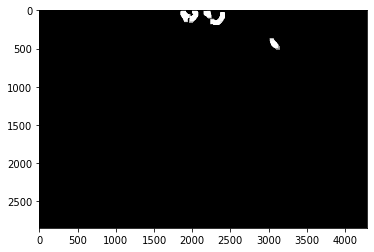

In [35]:
img_optic = cv2.imread('se_od31.jpg')
img_mask = cv2.imread(se_name)
img_vessel = cv2.imread('se_vessel31.jpg')

# set to gray
img_optic = cv2.cvtColor(img_optic, cv2.COLOR_BGR2GRAY)
img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
img_vessel = cv2.cvtColor(img_vessel, cv2.COLOR_BGR2GRAY)

# type transform
surface = img_f.astype(np.uint8)



# threshold vessel, subtract vessel
ret, img_vessel = cv2.threshold(img_vessel, img_vessel.max()*0.3, 255, cv2.THRESH_BINARY)
img_without_vessel = cv2.subtract(surface, img_vessel)

# threshold img_without_vessel
ret, img_without_vessel = cv2.threshold(img_without_vessel, 60, 255, cv2.THRESH_BINARY)

# remove noise point
img_without_vessel = cv2.blur(img_without_vessel,(15,15),0)

# threshold optic disc, subtract optic disc
ret, img_optic = cv2.threshold(img_optic, img_optic.max()*0.3, 255, cv2.THRESH_BINARY)
img_without_vo = cv2.subtract(img_without_vessel, img_optic)

# dilate retina mask
kernel = np.ones((10,10),np.uint8)
dilation = cv2.erode(mask_thresh,kernel,iterations = 5)
# plt.imshow(dilation,'gray')
# plt.show()

# get the thick retina frame
img_retinal = cv2.subtract(img_without_vo, dilation)
# plt.imshow(img_retinal,'gray')
# plt.show()

# subtract retina frame, get the soft exudates with noise point
img_soft_noise = cv2.subtract(img_without_vo, img_retinal)
# plt.imshow(img_soft_noise,'gray')
# plt.show()

# subtract noise point(vessel boundary)
img_final6 = cv2.subtract(mask_thresh, img_soft_noise)
# plt.imshow(img_final6,'gray')
# plt.show()
img_presoft = cv2.subtract(img_soft_noise, img_final6)
# plt.imshow(img_presoft,'gray')
# plt.show()

# opening operation to remove noise point
kernel = np.ones((20,20),np.uint8)
img_opening = cv2.morphologyEx(img_presoft, cv2.MORPH_OPEN, kernel)
# plt.imshow(img_opening,'gray')
# plt.show()

# dilate img_final, filing soft exudate center
kernel = np.ones((5,5),np.uint8)
img_final = cv2.dilate(img_opening,kernel,iterations = 6)
cv2.imwrite('se_img_final_31.jpg', img_final)
plt.imshow(img_final,'gray')
plt.show()

In [2]:
mask = cv2.imread(se_name)
result = cv2.imread('se_img_final_31.jpg')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

def evaluation(image, mask):
    
    zeros_list_img, one_list_img, zeros_list_mk, one_list_mk = [], [], [], []
    
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            val_mk = mask[i][j]
            val_img  = image[i][j]
            if val_mk == 0:
                zeros_list_mk.append((i,j))
            else:
                one_list_mk.append((i,j))
            if val_img == 0:
                zeros_list_img.append((i,j))
            else:
                one_list_img.append((i,j))
    #print(len(one_list_img))
    TP = len(set(one_list_img).intersection(set(one_list_mk)))
    TN = len(set(zeros_list_img).intersection(set(zeros_list_mk)))
    FP = len(set(one_list_img).intersection(set(zeros_list_mk)))
    FN = len(set(zeros_list_img).intersection(set(one_list_mk)))
    TPR = TP/(FN + TP)
    TNR = TN/(TN + FP)
    P = TP/(TP + FP)
    R = TP/(TP + FN)
    F = 2*(R*P/(R + P))
    JSC = TP/(TP + FP + FN)
    DSC = 2*(TP/(FP + 2*TP + FN))
    return TPR, TNR, F, JSC, DSC

result:


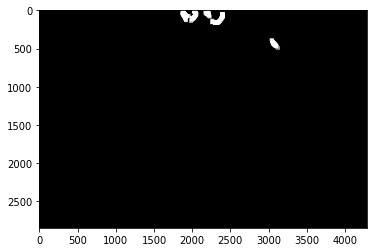

masks_Soft_Exudates:


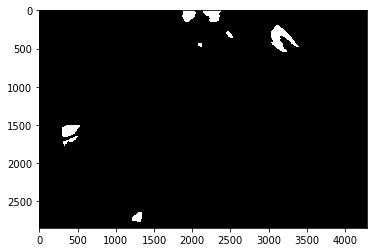

------------------------
JSC = 0.21047908008464852


In [3]:
print('result:')
plt.imshow(result,'gray')
plt.show()

print('masks_Soft_Exudates:')
plt.imshow(mask,'gray')
plt.show()

print('------------------------')
TPR, TNR, F, JSC, DSC = evaluation(mask, result)
print('JSC = ', end = '')
print(JSC)